In [1]:

#imports and input file
model_list = []
column_list = ['epochs','overall accuracy','difference from baseline' ,'yes accuracy'] #f1 score is harmonic mean of accuracy and recall/sensitivity(yes score). recall score

#import files
from io import StringIO
import requests
import json
import pandas as pd
from pandas import Series, DataFrame

from sklearn import datasets
from sklearn.cross_validation import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

#import balancing techniques
import imblearn
from imblearn.over_sampling import ADASYN

#neural network model imports
import keras as K
from keras.models import Sequential
from keras.layers import Dense
import numpy as np

# fix random seed for reproducibility
np.random.seed(7)
from sklearn.preprocessing import StandardScaler

#random forrest imports
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score

#from sklearn.preprocessing import balance_weights #to balance

#logistic l1 regularization imports
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#decision tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# @hidden_cell
# This function accesses a file in your Object Storage. The definition contains your credentials.
# You might want to remove those credentials before you share your notebook.
def get_object_storage_file_with_credentials_26adc31ece2740d9a52b41db6ee3541b(container, filename):
    """This functions returns a StringIO object containing
    the file content from Bluemix Object Storage."""

    url1 = ''.join(['https://identity.open.softlayer.com', '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': 'member_9ba378027bf714f2ca74f0acfb809adb7535884b','domain': {'id': 'ce2b15e5802c44918d4ed1a3c22e867e'},
            'password': 'j1Pa-u3b7o/OR,cQ'}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                        if(e2['interface']=='public'and e2['region']=='dallas'):
                            url2 = ''.join([e2['url'],'/', container, '/', filename])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.get(url=url2, headers=headers2)
    return StringIO(resp2.text)
#read input
ba = pd.read_csv(get_object_storage_file_with_credentials_26adc31ece2740d9a52b41db6ee3541b('DefaultProjectrohanchakraborty1ibmcom', 'bank-additional-full.csv'), sep = ';')



#bank_reorder contains all numerical values
bank_reorder = (ba.select_dtypes(exclude=['object'])) #dataframe containing columns with numerical values
del bank_reorder['duration'] #deleting duration since that can not be known beforehand
categorical_bank = (ba.select_dtypes(include=['object'])) #dataframe containing columns with all non-numerical values

#1 hot encoding/dummy encoding 
for col in list(categorical_bank):#for each column (col) in the list of columns of the non-numerical columns
    one_hot = pd.get_dummies((categorical_bank[str(col)]))
    bank_reorder = bank_reorder.join(one_hot, rsuffix=('_'+str(col)))#adding each encoding 

del bank_reorder['no_y']#delete  y no since no unknown y's and y no is simply inverse of y_yes
x = bank_reorder.iloc[:,:(bank_reorder.shape[1]-1)]#all columns except last column are part of x
y = bank_reorder.iloc[:,(bank_reorder.shape[1]-1):bank_reorder.shape[1]]#only last column is y

#splitting into training and test values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)#.values
#fixing class imbalance

#balancing techniques
ada = ADASYN()#using synthetic data generation
x_resampled, y_resampled = ada.fit_sample(x_train.values, y_train.values.ravel())
y_resampled = y_resampled.reshape(y_resampled.shape[0],1)

/gpfs/fs01/user/s2cc-2e5d599dfbd7e0-6f6b16f77516/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [2]:
baseline = (ba['y'].value_counts()/ba.shape[0])
base = baseline[0]

In [3]:
#neural networks creation. 

def neural_net(x_vals, y_vals,balancing, eps):
    #neural network 
    model_neural = Sequential()

    # Add an input layer 18 is the number of hidden units (earlier 12) more units = more patterns
    model_neural.add(Dense(18, activation='relu', input_shape=(x_vals.shape[1],)))

    # Add one hidden layer 
    model_neural.add(Dense(12, activation='relu'))

    # Add an output layer 
    model_neural.add(Dense(1, activation='sigmoid'))

    #compile
    model_neural.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics= ['binary_accuracy'])
    
    if balancing=='class_weights':
        model_neural.fit(x_vals, y_vals, epochs =eps, batch_size=1, class_weight={0:1, 1:8})
    else:
        model_neural.fit(x_vals, y_vals, epochs =eps, batch_size=1) 
    
    y_preds = model_neural.predict_classes(x_test.values)
    accuracy = accuracy_score(y_test, y_preds)
    model_list.append((str(eps), accuracy,(accuracy-base),recall_score(y_test, y_preds) ))
# 'epochs','overall accuracy','difference from baseline' ,'yes accuracy'] 
    
    
    
    
epochs_vals = [1, 3,5, 10 ] # 15, 50, 100, 200, 300  

for epoch in epochs_vals:
    neural_net(x_train.values, y_train.values, 'class_weights', epoch)





#evaluate basic
#to do = method balancing technique result(multiple types). Currently only map. Can create object/list with outputs to print out
#score_neural = model_neural.evaluate(x_test.values, y_test.values,verbose=1)
#print(score_neural)

Epoch 1/1
28831/28831 [==============================] - 31s - loss: 14.1442 - binary_accuracy: 0.1128    
Epoch 2/3
28831/28831 [==============================] - 30s - loss: 14.1442 - binary_accuracy: 0.1128    
Epoch 3/3
12357/12357 [==============================] - 0s     
Epoch 1/5
28831/28831 [==============================] - 30s - loss: 14.1442 - binary_accuracy: 0.1128    
Epoch 2/5
28831/28831 [==============================] - 30s - loss: 14.1442 - binary_accuracy: 0.1128    
Epoch 3/5
28831/28831 [==============================] - 29s - loss: 14.1442 - binary_accuracy: 0.1128    
Epoch 4/5
28831/28831 [==============================] - 30s - loss: 14.1442 - binary_accuracy: 0.1128    
Epoch 5/5
28831/28831 [==============================] - 29s - loss: 14.5444 - binary_accuracy: 0.8872    
Epoch 2/10
28831/28831 [==============================] - 29s - loss: 14.5444 - binary_accuracy: 0.8872    
Epoch 3/10
28831/28831 [==============================] - 29s - loss: 14.5444 

In [4]:
df = pd.DataFrame(model_list, columns = column_list)
df.sort_values(by=['yes accuracy'], ascending=False)


,epochs,overall accuracy,difference from baseline,yes accuracy
0,1,0.112325,-0.775021,1.0
1,3,0.112325,-0.775021,1.0
2,5,0.112325,-0.775021,1.0
3,10,0.887675,0.000329,0.0


Populating the interactive namespace from numpy and matplotlib


/usr/local/src/conda3_runtime.v16/4.1.1/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


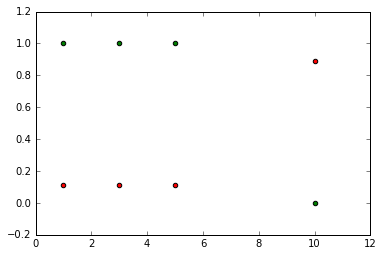

In [5]:
%pylab inline
import matplotlib as mpl
mpl.use('agg')
import matplotlib.pyplot as plt
x=[1, 2, 3]
y = [4, 5, 6]
#plt.scatter([1,2,3,4],[2,4,6,8], c='red', mark = 'cross')
#plt.scatter([1,1,1,1],[2,4,6,8], c='blue')
#plt.scatter(x, y)
plt.scatter(df['epochs'], df['overall accuracy'], c='red')
plt.scatter(df['epochs'], df['yes accuracy'], c='green')

#plt.plot(df['epochs'], df['overall accuracy'])
#plt.plot(df['epochs'], df['yes accuracy'])

#plt.show()

In [ ]:
#http://www.scipy-lectures.org/intro/matplotlib/matplotlib.html
#https://www.datacamp.com/community/tutorials/matplotlib-tutorial-python#gs.lo3XbFA
#https://pythonspot.com/en/matplotlib-scatterplot/